In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split

# Enhanced Data Augmentation
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.RandomRotation(15),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load CIFAR-10 Dataset
batch_size = 128
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Train/Validation/Test Split
train_size = int(0.7 * len(train_set))
val_size = int(0.1 * len(train_set))
test_size = len(train_set) - train_size - val_size
train_set, val_set, _ = random_split(train_set, [train_size, val_size, test_size])

train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


100%|██████████| 170498071/170498071 [00:05<00:00, 29243611.90it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [2]:
import torchvision.models as models

# Models
alexnet = models.alexnet(pretrained=False, num_classes=10).to(device)
resnet50 = models.resnet50(pretrained=False, num_classes=10).to(device)

# Optimizers and Schedulers
optimizer_alexnet = torch.optim.Adam(alexnet.parameters(), lr=0.001)
optimizer_resnet50 = torch.optim.Adam(resnet50.parameters(), lr=0.0001)  # Reduced LR

scheduler_resnet50 = torch.optim.lr_scheduler.StepLR(optimizer_resnet50, step_size=5, gamma=0.5)  # LR Scheduler


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [3]:
import torch.nn as nn

criterion = nn.CrossEntropyLoss()

def train_model_with_patience(model, optimizer, scheduler=None, num_epochs=50, patience=3):
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_val_loss = float('inf')
    no_improvement_epochs = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_acc = 100 * val_correct / val_total
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.2f}%")

        if scheduler:
            scheduler.step()

        # Early Stopping with Patience
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            no_improvement_epochs = 0
        else:
            no_improvement_epochs += 1
            if no_improvement_epochs >= patience:
                print(f"Validation loss increased for {patience} epochs. Stopping early at epoch {epoch+1}.")
                break

    return train_losses, val_losses, train_accuracies, val_accuracies


In [4]:
import time

# Train AlexNet
print("Training AlexNet...")
start_time = time.time()
alexnet_results = train_model_with_patience(alexnet, optimizer_alexnet)
alexnet_time = time.time() - start_time

# Train ResNet50
print("\nTraining ResNet50...")
start_time = time.time()
resnet50_results = train_model_with_patience(resnet50, optimizer_resnet50, scheduler_resnet50)
resnet50_time = time.time() - start_time


Training AlexNet...
Epoch [1/50], Train Loss: 1.9359, Train Accuracy: 27.83%, Val Loss: 1.6864, Val Accuracy: 36.98%
Epoch [2/50], Train Loss: 1.6709, Train Accuracy: 38.31%, Val Loss: 1.5774, Val Accuracy: 42.64%
Epoch [3/50], Train Loss: 1.5687, Train Accuracy: 42.62%, Val Loss: 1.4770, Val Accuracy: 45.86%
Epoch [4/50], Train Loss: 1.4765, Train Accuracy: 46.49%, Val Loss: 1.4007, Val Accuracy: 48.46%
Epoch [5/50], Train Loss: 1.4070, Train Accuracy: 48.80%, Val Loss: 1.3360, Val Accuracy: 51.58%
Epoch [6/50], Train Loss: 1.3654, Train Accuracy: 50.75%, Val Loss: 1.3476, Val Accuracy: 52.10%
Epoch [7/50], Train Loss: 1.3206, Train Accuracy: 52.67%, Val Loss: 1.2662, Val Accuracy: 54.00%
Epoch [8/50], Train Loss: 1.2829, Train Accuracy: 53.94%, Val Loss: 1.2352, Val Accuracy: 55.72%
Epoch [9/50], Train Loss: 1.2453, Train Accuracy: 55.34%, Val Loss: 1.2367, Val Accuracy: 56.22%
Epoch [10/50], Train Loss: 1.2405, Train Accuracy: 55.65%, Val Loss: 1.1981, Val Accuracy: 57.90%
Epoch [11

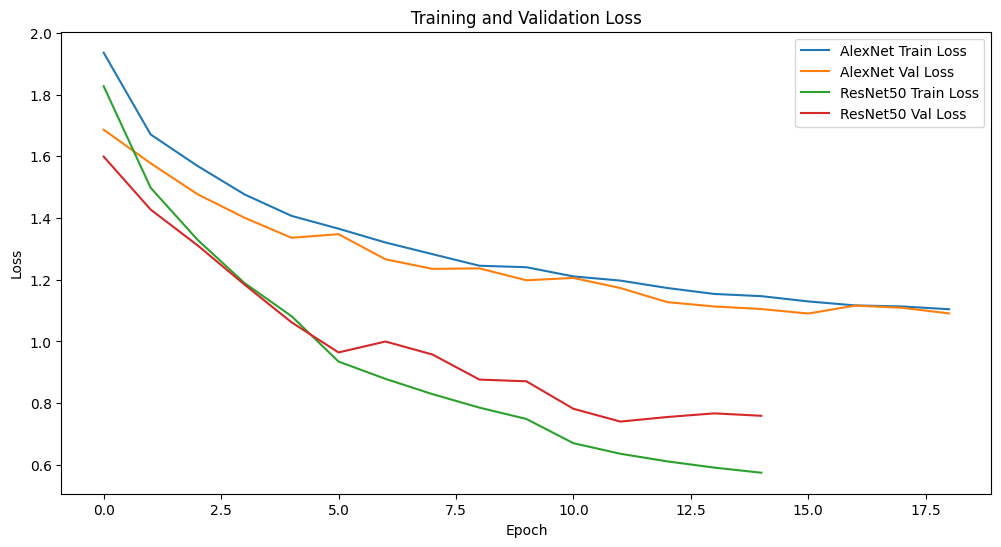

In [5]:
import matplotlib.pyplot as plt

alexnet_train_losses, alexnet_val_losses = alexnet_results[:2]
resnet50_train_losses, resnet50_val_losses = resnet50_results[:2]

plt.figure(figsize=(12, 6))
plt.plot(alexnet_train_losses, label="AlexNet Train Loss")
plt.plot(alexnet_val_losses, label="AlexNet Val Loss")
plt.plot(resnet50_train_losses, label="ResNet50 Train Loss")
plt.plot(resnet50_val_losses, label="ResNet50 Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.show()


Visualizing Activations for AlexNet...


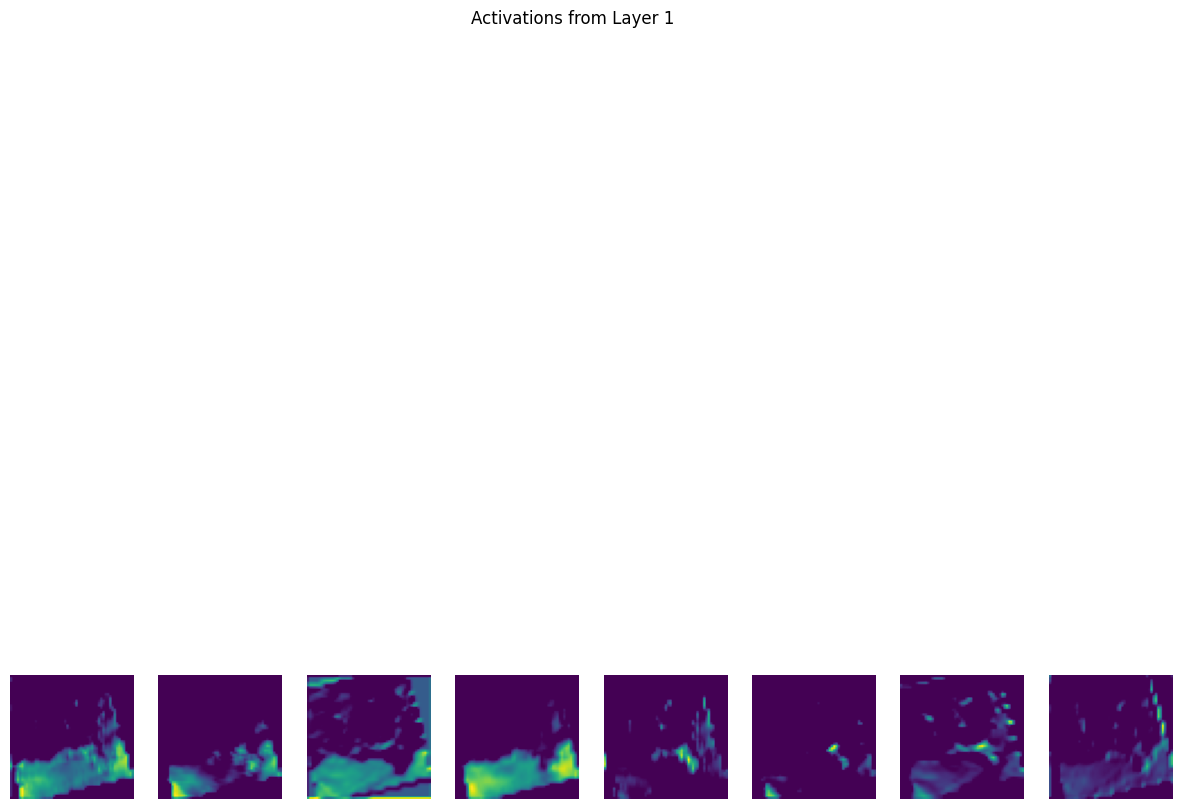

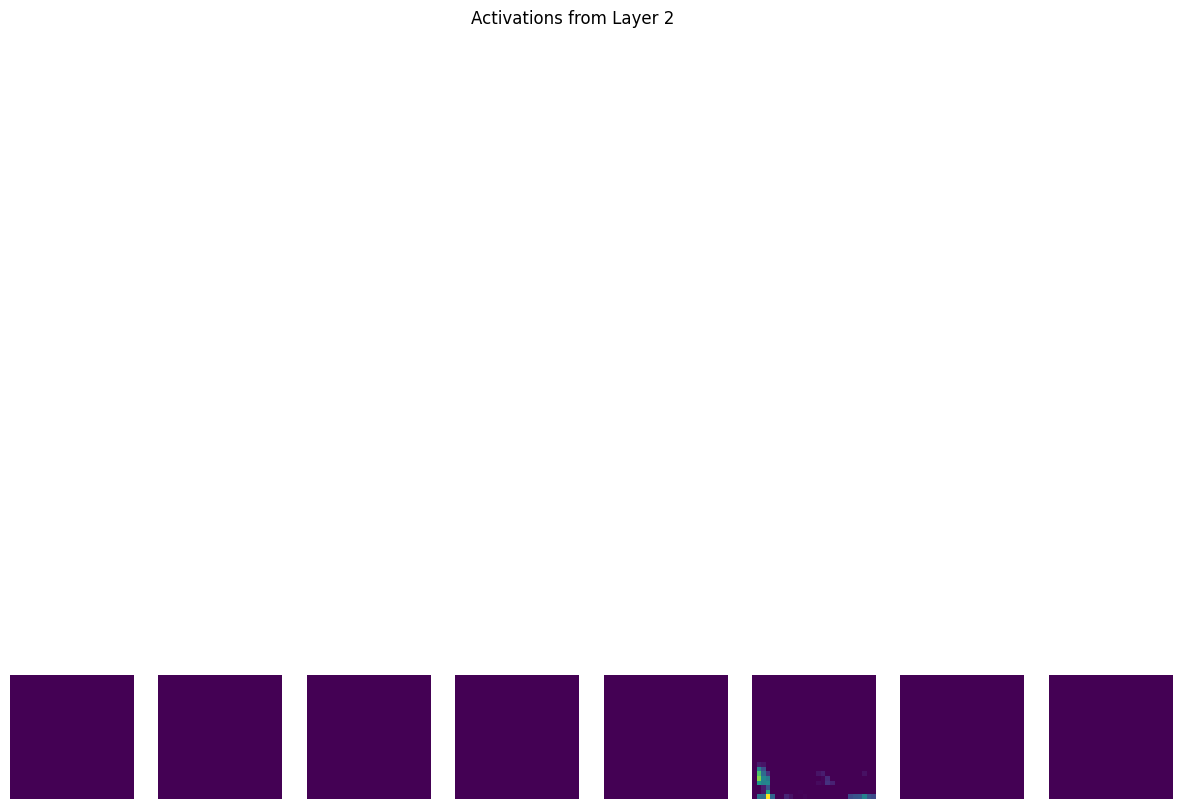

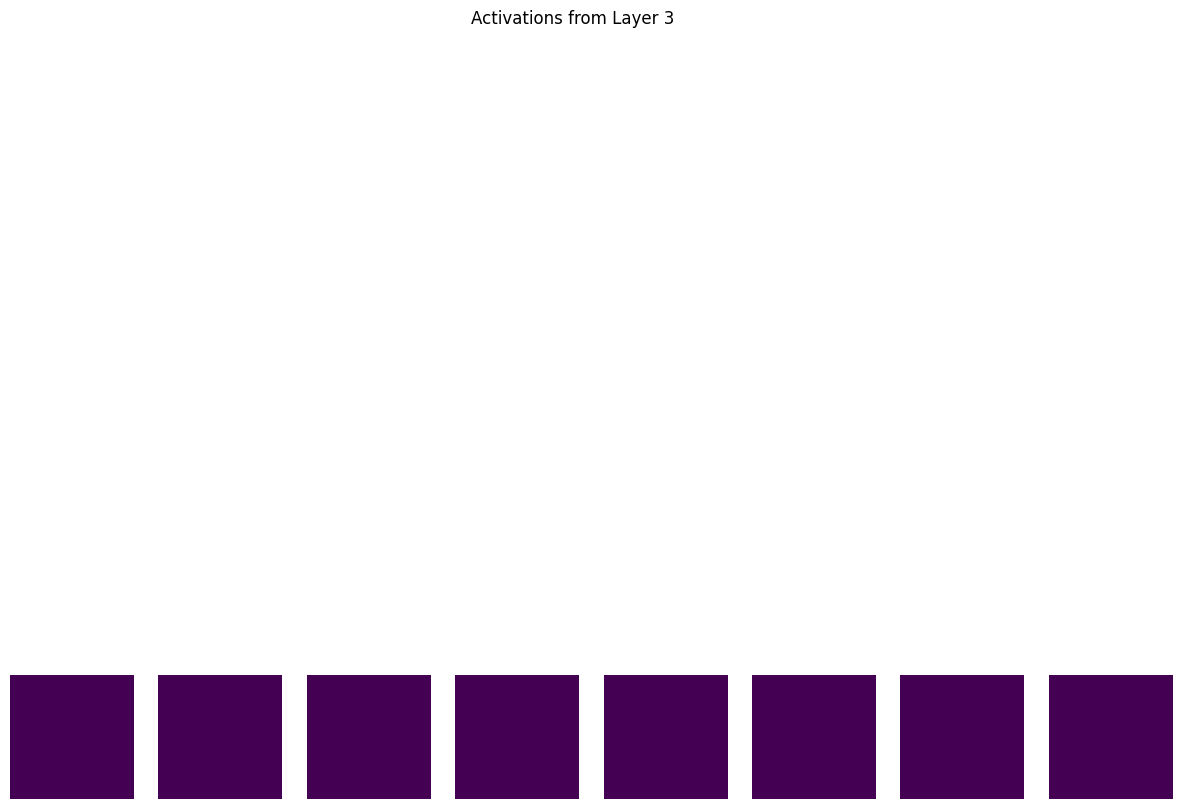

Visualizing Activations for ResNet50...


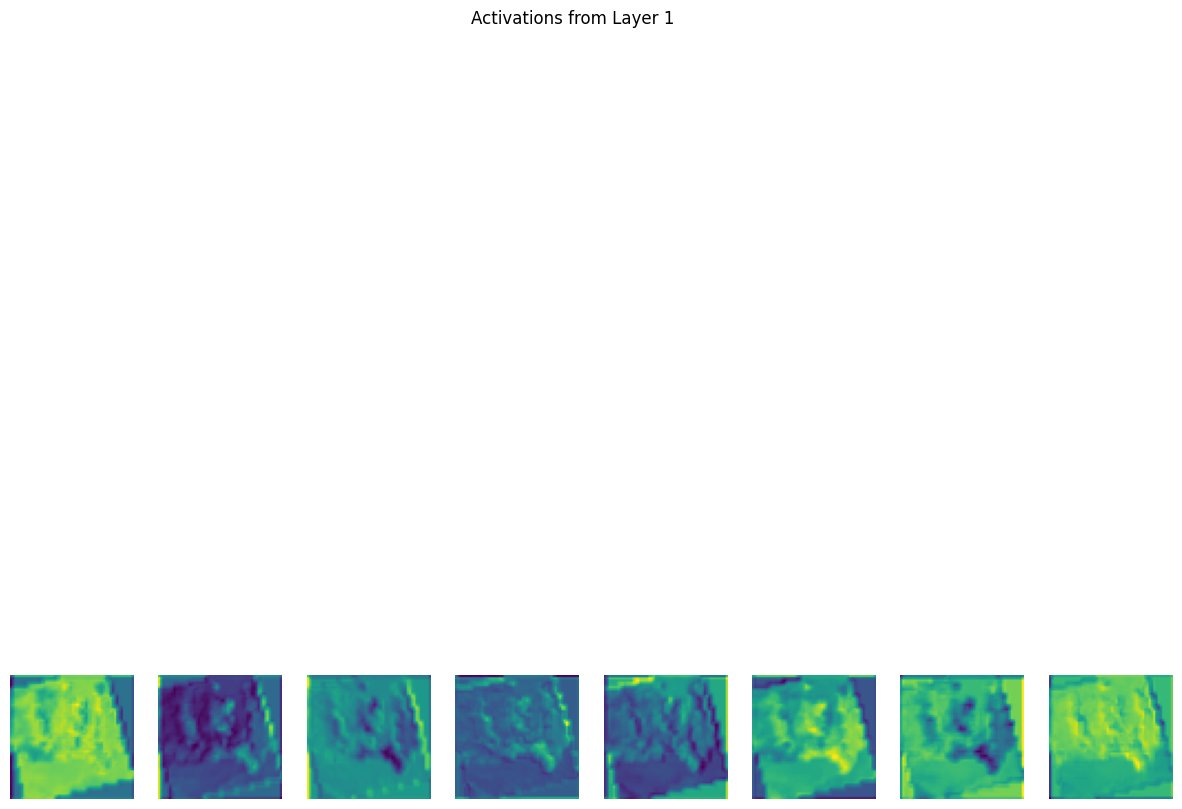

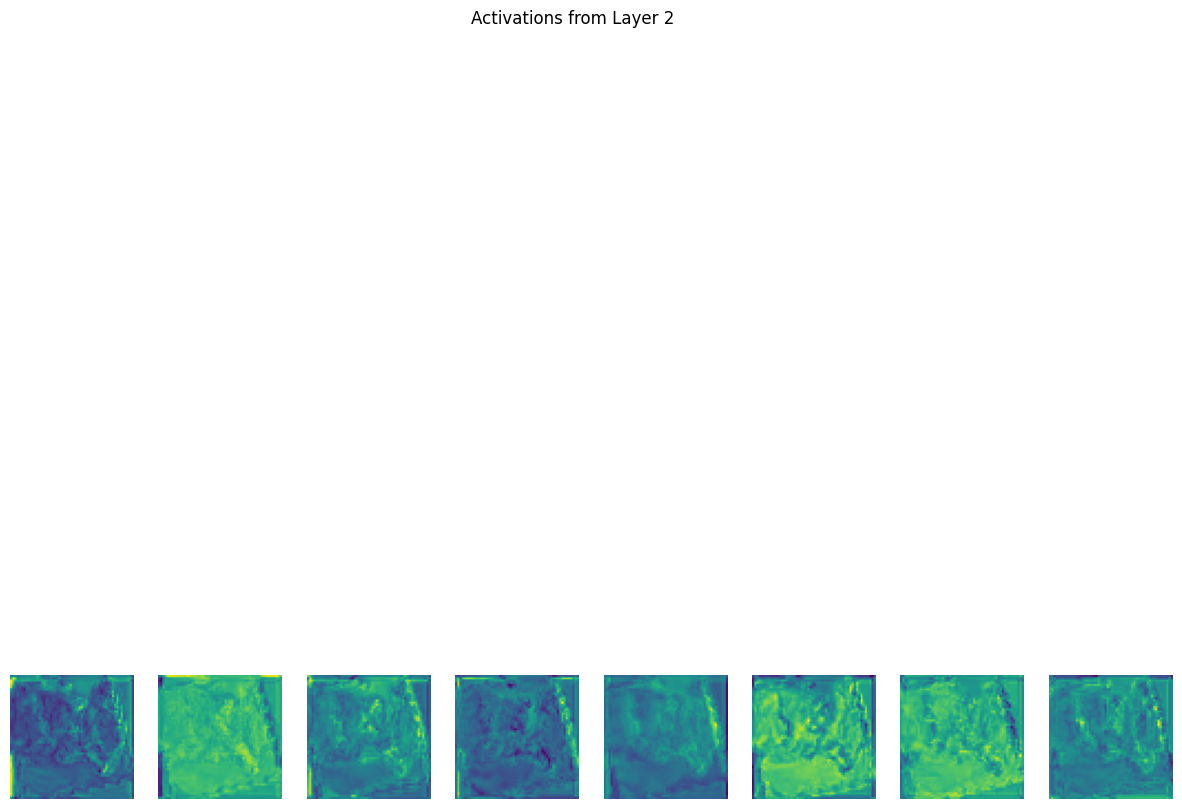

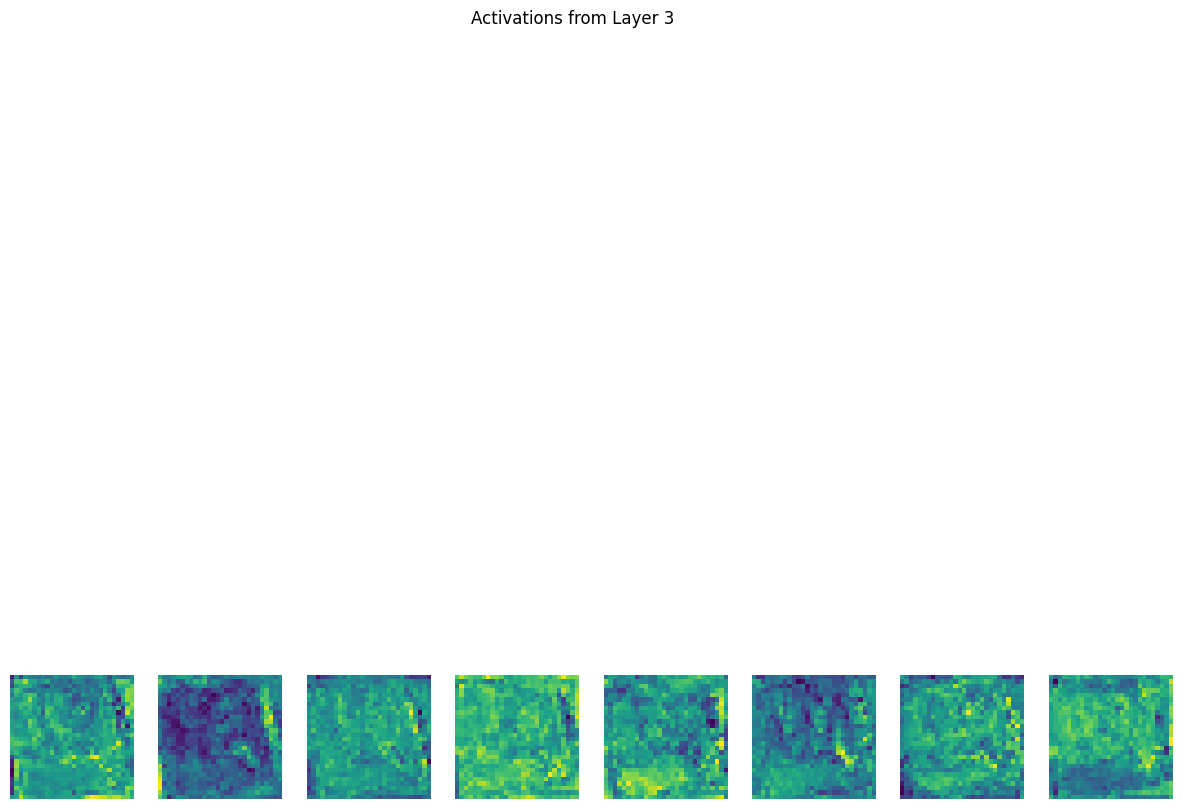

In [6]:
import matplotlib.pyplot as plt

def visualize_activation_maps(model, images):
    """
    Visualizes activation maps from a few layers of the CNN.
    :param model: Trained CNN model (e.g., AlexNet or ResNet50)
    :param images: Input batch of images
    """
    model.eval()
    images = images.to(device)

    # Register hooks to extract intermediate activations
    activations = []
    def hook(module, input, output):
        activations.append(output)

    # Pick a few layers for activation visualization
    if isinstance(model, models.AlexNet):
        layers_to_visualize = [model.features[0], model.features[3], model.features[8]]  # Conv Layers
    elif isinstance(model, models.ResNet):
        layers_to_visualize = [model.layer1[0].conv1, model.layer2[0].conv1, model.layer3[0].conv1]  # Conv Layers

    hooks = []
    for layer in layers_to_visualize:
        hooks.append(layer.register_forward_hook(hook))

    # Forward pass
    _ = model(images)

    # Visualize activations
    for i, activation in enumerate(activations):
        activation = activation.cpu().detach()
        num_filters = activation.shape[1]  # Number of filters
        fig, axes = plt.subplots(1, min(8, num_filters), figsize=(15, 15))
        for j in range(min(8, num_filters)):  # Visualize up to 8 filters
            axes[j].imshow(activation[0, j].numpy(), cmap='viridis')
            axes[j].axis('off')
        plt.suptitle(f"Activations from Layer {i+1}")
        plt.show()

    # Remove hooks
    for hook in hooks:
        hook.remove()

# Get a batch of test images
images, _ = next(iter(test_loader))

# Visualize activation maps for AlexNet
print("Visualizing Activations for AlexNet...")
visualize_activation_maps(alexnet, images[:4])

# Visualize activation maps for ResNet50
print("Visualizing Activations for ResNet50...")
visualize_activation_maps(resnet50, images[:4])


In [7]:
def test_model(model):
    model.eval()
    correct, total = 0, 0
    test_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    accuracy = 100 * correct / total
    return test_loss, accuracy

# Compute Test Accuracy
alexnet_test_loss, alexnet_test_accuracy = test_model(alexnet)
resnet50_test_loss, resnet50_test_accuracy = test_model(resnet50)

print(f"AlexNet Test Loss: {alexnet_test_loss:.4f}, Test Accuracy: {alexnet_test_accuracy:.2f}%")
print(f"ResNet50 Test Loss: {resnet50_test_loss:.4f}, Test Accuracy: {resnet50_test_accuracy:.2f}%")


AlexNet Test Loss: 1.0807, Test Accuracy: 62.46%
ResNet50 Test Loss: 0.7436, Test Accuracy: 74.46%


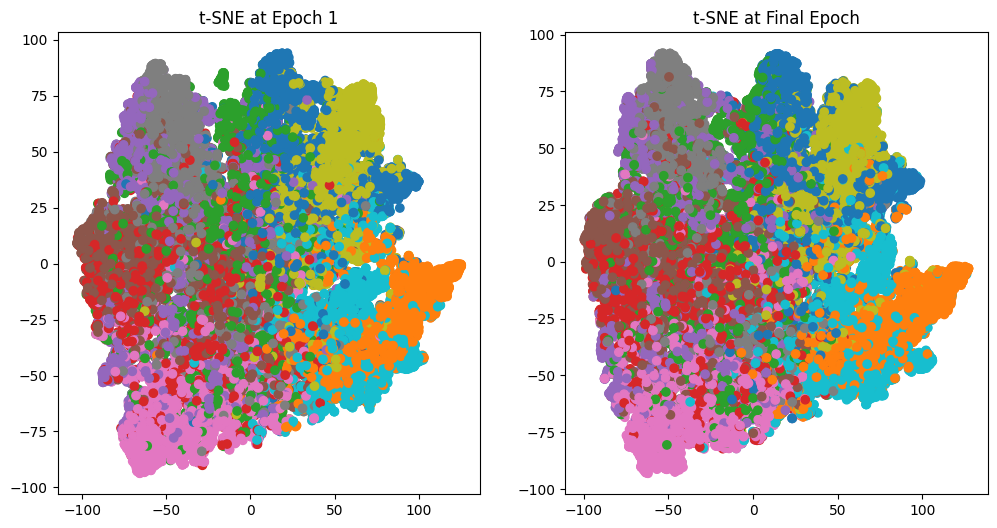

In [8]:
from sklearn.manifold import TSNE
import numpy as np

def extract_features(model, loader):
    model.eval()
    features, labels_list = [], []
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            outputs = model(images)
            features.append(outputs.cpu().numpy())
            labels_list.append(labels.numpy())
    return np.concatenate(features), np.concatenate(labels_list)

# Extract bottleneck features
features_epoch1, labels_epoch1 = extract_features(alexnet, train_loader)  # Adjust for epoch 1
features_epoch_final, labels_epoch_final = extract_features(alexnet, train_loader)  # Adjust for final epoch

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
features_tsne1 = tsne.fit_transform(features_epoch1)
features_tsne_final = tsne.fit_transform(features_epoch_final)

# Plot t-SNE
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.scatter(features_tsne1[:, 0], features_tsne1[:, 1], c=labels_epoch1, cmap='tab10')
plt.title("t-SNE at Epoch 1")
plt.subplot(1, 2, 2)
plt.scatter(features_tsne_final[:, 0], features_tsne_final[:, 1], c=labels_epoch_final, cmap='tab10')
plt.title("t-SNE at Final Epoch")
plt.show()


ResNet50 outperformed AlexNet with a test accuracy of 74.46% compared to AlexNet's 62.46%, while also achieving a lower test loss (0.7436 vs. 1.0807) and stabilizing within fewer epochs (15 vs. 19). ResNet50's deeper architecture and residual connections enabled better feature learning and generalization, as evidenced by its higher accuracy and lower loss. In contrast, AlexNet's activation maps for layers 2 and 3 being single-colored suggest limited feature diversity, potentially indicating underutilized capacity. While AlexNet is less resource-intensive, ResNet50 is the preferred model for this task due to its significantly better performance, provided sufficient computational resources are available.

In [9]:
import os
import glob
import unicodedata
import string
import torch
import torch.nn as nn
import random
import matplotlib.pyplot as plt

# Constants and Helpers
ALL_LETTERS = string.ascii_letters + " .,;'"
N_LETTERS = len(ALL_LETTERS) + 1  # +1 for EOS token

def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn' and c in ALL_LETTERS
    )

def read_lines(filename):
    with open(filename, encoding='utf-8') as f:
        return [unicode_to_ascii(line.strip()) for line in f]

# Load data
data_path = '/kaggle/input/nlp-dl/data/names/*.txt'
category_lines = {}
all_categories = []

for filename in glob.glob(data_path):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = read_lines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
if n_categories == 0:
    raise RuntimeError("Data not found. Ensure `/kaggle/input/nlp-dl/data/names` directory is correctly loaded.")

def letter_to_index(letter):
    return ALL_LETTERS.find(letter)

def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, N_LETTERS)
    for li, letter in enumerate(line):
        tensor[li][0][letter_to_index(letter)] = 1
    return tensor


In [10]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        rnn_output, hidden = self.rnn(input, hidden)
        output = self.fc(rnn_output[-1])
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size)


In [11]:
criterion = nn.NLLLoss()
learning_rate = 0.005

def train_rnn(category_tensor, line_tensor):
    hidden = rnn_model.init_hidden()

    rnn_model.zero_grad()
    output, hidden = rnn_model(line_tensor, hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in rnn_model.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

def evaluate_rnn(line_tensor):
    hidden = rnn_model.init_hidden()
    output, hidden = rnn_model(line_tensor, hidden)
    return output

def random_training_example():
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = torch.tensor([all_categories.index(category)], dtype=torch.long)
    line_tensor = line_to_tensor(line)
    return category, line, category_tensor, line_tensor


5000 2.8131 Michel / Czech ✗ (Spanish)
10000 2.9776 Kennedy / Dutch ✗ (Scottish)
15000 1.3563 Mak / Korean ✗ (Chinese)
20000 2.3547 Hellewege / Dutch ✗ (German)
25000 1.2517 Hong / Chinese ✗ (Korean)
30000 2.6440 Lewis / Greek ✗ (English)
35000 1.4257 Mcintyre / Dutch ✗ (Scottish)
40000 1.3777 You / Korean ✗ (Chinese)
45000 0.5657 Bing / Chinese ✓
50000 1.8700 Greco / Spanish ✗ (Italian)
55000 0.1438 Duong / Vietnamese ✓
60000 0.0062 Yakushkov / Russian ✓
65000 3.5605 Sioda / Japanese ✗ (Irish)
70000 0.8734 Lieu / Vietnamese ✓
75000 0.9938 Kafka / Japanese ✗ (Czech)
80000 1.0922 Kazmier / Czech ✓
85000 0.1768 Zhou / Chinese ✓
90000 0.4286 Maes / Dutch ✓
95000 0.5389 Ahn / Korean ✓
100000 0.6114 Xun / Chinese ✓


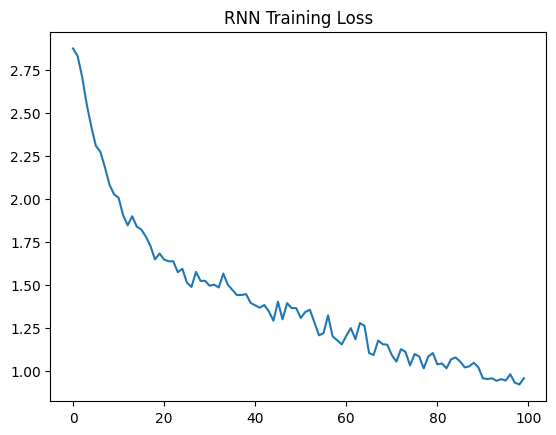

In [12]:
n_hidden = 128
rnn_model = RNNModel(N_LETTERS, n_hidden, n_categories)

n_iters = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = random_training_example()
    output, loss = train_rnn(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess = all_categories[output.topk(1)[1].item()]
        correct = '✓' if guess == category else f'✗ ({category})'
        print(f'{iter} {loss:.4f} {line} / {guess} {correct}')

    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

# Plot training loss
plt.figure()
plt.plot(all_losses)
plt.title('RNN Training Loss')
plt.show()


RNN Accuracy: 65.30%


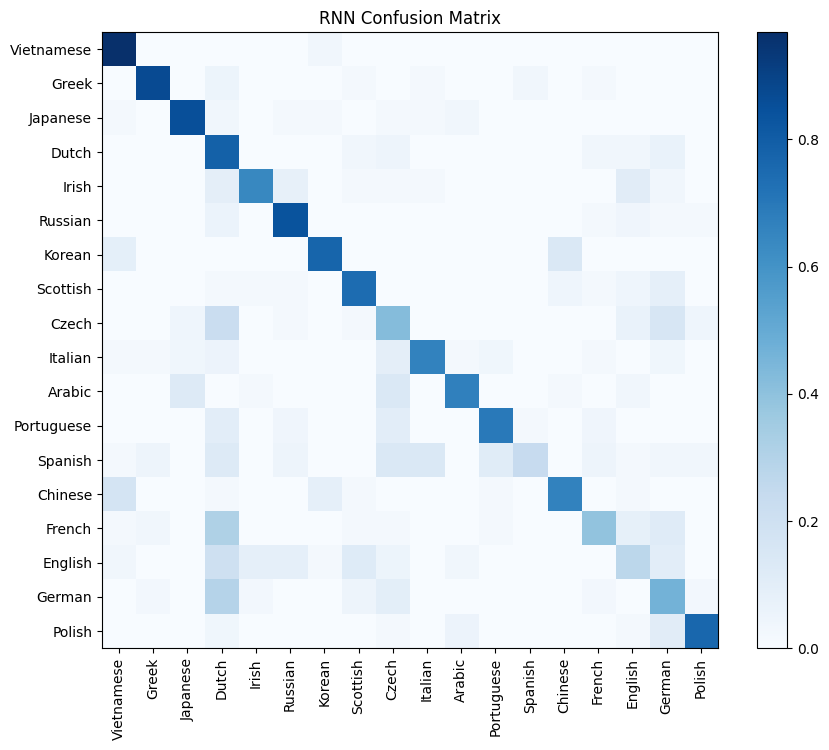

In [13]:
confusion_rnn = torch.zeros(n_categories, n_categories)
correct_rnn = 0
total_rnn = 0

n_confusion = 1000
for _ in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_example()
    output = evaluate_rnn(line_tensor)
    guess = output.topk(1)[1].item()
    category_index = all_categories.index(category)
    confusion_rnn[category_index][guess] += 1

    if guess == category_index:
        correct_rnn += 1
    total_rnn += 1

for i in range(n_categories):
    confusion_rnn[i] = confusion_rnn[i] / confusion_rnn[i].sum()

accuracy_rnn = correct_rnn / total_rnn
print(f"RNN Accuracy: {accuracy_rnn * 100:.2f}%")

# Plot confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(confusion_rnn.numpy(), interpolation='nearest', cmap='Blues')
plt.title('RNN Confusion Matrix')
plt.colorbar()
plt.xticks(range(n_categories), all_categories, rotation=90)
plt.yticks(range(n_categories), all_categories)
plt.show()


In [14]:
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(GRUModel, self).__init__()
        self.hidden_size = hidden_size
        self.gru = nn.GRU(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        gru_output, hidden = self.gru(input, hidden)
        output = self.fc(gru_output[-1])
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return torch.zeros(1, 1, self.hidden_size)


In [15]:
def train_gru(category_tensor, line_tensor):
    hidden = gru_model.init_hidden()

    gru_model.zero_grad()
    output, hidden = gru_model(line_tensor, hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in gru_model.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

def evaluate_gru(line_tensor):
    hidden = gru_model.init_hidden()
    output, hidden = gru_model(line_tensor, hidden)
    return output


5000 2.8989 Kikkert / Irish ✗ (Dutch)
10000 2.7550 Saliba / Japanese ✗ (Arabic)
15000 1.1926 Kolovos / Greek ✓
20000 1.6884 Fionn / Irish ✓
25000 2.3514 Pecora / Spanish ✗ (Italian)
30000 2.4549 Koeman / Irish ✗ (Dutch)
35000 2.3939 Wallace / French ✗ (Scottish)
40000 2.1268 Szweda / Spanish ✗ (Polish)
45000 0.1341 Nomikos / Greek ✓
50000 0.6012 Smolak / Polish ✓
55000 1.2415 Sung / Chinese ✗ (Korean)
60000 0.8198 Heppenheimer / German ✓
65000 5.4615 Rompa / Spanish ✗ (Dutch)
70000 1.8887 Yakon / English ✗ (Russian)
75000 1.6416 D'cruze / French ✗ (Portuguese)
80000 0.6266 Mei / Chinese ✓
85000 1.3848 Campana / Spanish ✗ (Italian)
90000 2.6387 Kinder / Dutch ✗ (English)
95000 5.5241 Paulis / Greek ✗ (Dutch)
100000 0.2959 Dam / Vietnamese ✓


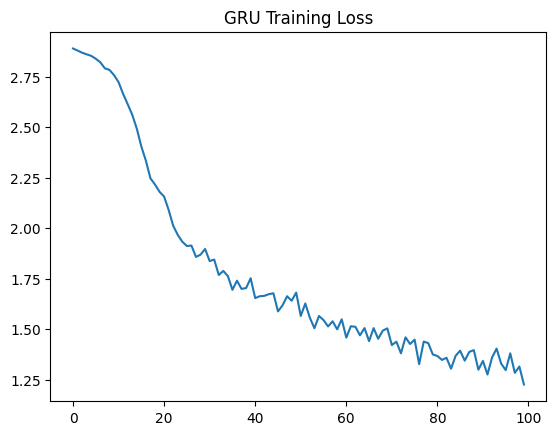

In [16]:
gru_model = GRUModel(N_LETTERS, n_hidden, n_categories)

current_loss = 0
all_losses = []

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = random_training_example()
    output, loss = train_gru(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess = all_categories[output.topk(1)[1].item()]
        correct = '✓' if guess == category else f'✗ ({category})'
        print(f'{iter} {loss:.4f} {line} / {guess} {correct}')

    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

plt.figure()
plt.plot(all_losses)
plt.title('GRU Training Loss')
plt.show()


GRU Accuracy: 54.70%


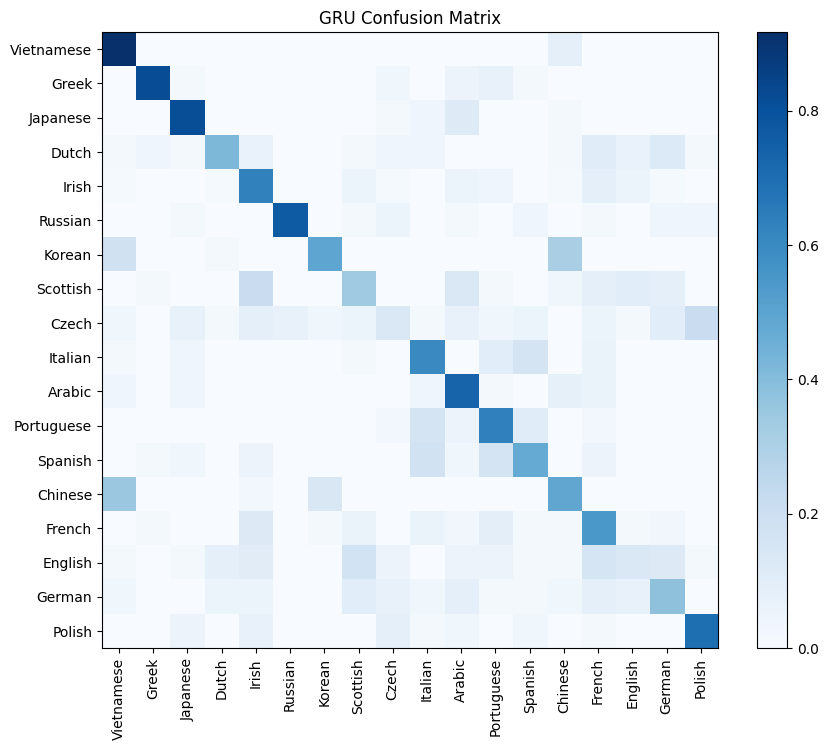

In [17]:
confusion_gru = torch.zeros(n_categories, n_categories)
correct_gru = 0
total_gru = 0

for _ in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_example()
    output = evaluate_gru(line_tensor)
    guess = output.topk(1)[1].item()
    category_index = all_categories.index(category)
    confusion_gru[category_index][guess] += 1

    if guess == category_index:
        correct_gru += 1
    total_gru += 1

for i in range(n_categories):
    confusion_gru[i] = confusion_gru[i] / confusion_gru[i].sum()

accuracy_gru = correct_gru / total_gru
print(f"GRU Accuracy: {accuracy_gru * 100:.2f}%")

plt.figure(figsize=(10, 8))
plt.imshow(confusion_gru.numpy(), interpolation='nearest', cmap='Blues')
plt.title('GRU Confusion Matrix')
plt.colorbar()
plt.xticks(range(n_categories), all_categories, rotation=90)
plt.yticks(range(n_categories), all_categories)
plt.show()


In [18]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        lstm_output, hidden = self.lstm(input, hidden)
        output = self.fc(lstm_output[-1])
        output = self.softmax(output)
        return output, hidden

    def init_hidden(self):
        return (torch.zeros(1, 1, self.hidden_size),  # Hidden state
                torch.zeros(1, 1, self.hidden_size))  # Cell state


In [19]:
def train_lstm(category_tensor, line_tensor):
    hidden = lstm_model.init_hidden()

    lstm_model.zero_grad()
    output, hidden = lstm_model(line_tensor, hidden)

    loss = criterion(output, category_tensor)
    loss.backward()

    for p in lstm_model.parameters():
        p.data.add_(p.grad.data, alpha=-learning_rate)

    return output, loss.item()

def evaluate_lstm(line_tensor):
    hidden = lstm_model.init_hidden()
    output, hidden = lstm_model(line_tensor, hidden)
    return output


5000 2.9165 Meeuwissen / Scottish ✗ (Dutch)
10000 2.8237 Mui / Russian ✗ (Chinese)
15000 2.8053 Rousseau / Dutch ✗ (French)
20000 2.9500 Trang / Irish ✗ (Vietnamese)
25000 2.7455 Sauvage / German ✗ (French)
30000 2.2793 Hintzen / English ✗ (German)
35000 3.4134 Bahr / Vietnamese ✗ (German)
40000 2.4410 Sault / Scottish ✗ (French)
45000 3.7167 San nicolas / Greek ✗ (Spanish)
50000 0.8829 Nonomura / Japanese ✓
55000 1.3979 Youn / Chinese ✗ (Korean)
60000 1.3794 Durant / French ✓
65000 0.0468 Papoutsis / Greek ✓
70000 1.3075 Sun / Chinese ✗ (Korean)
75000 2.6653 Calabrese / French ✗ (Italian)
80000 1.1623 Johnston / Scottish ✓
85000 5.8638 Kokkali / Polish ✗ (Greek)
90000 0.1240 Ajibana / Japanese ✓
95000 3.1496 Smith / German ✗ (Scottish)
100000 1.3662 Rusnak / Czech ✗ (Polish)


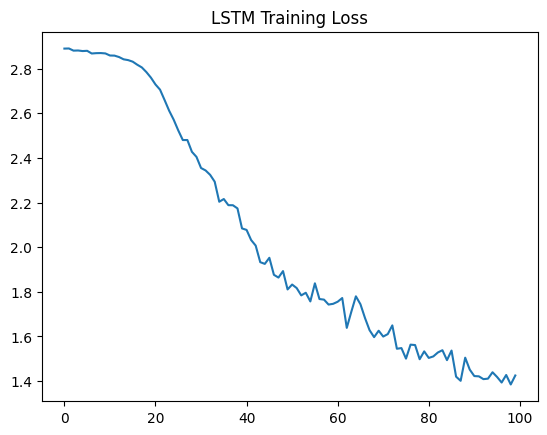

In [20]:
lstm_model = LSTMModel(N_LETTERS, n_hidden, n_categories)

current_loss = 0
all_losses = []

for iter in range(1, n_iters + 1):
    category, line, category_tensor, line_tensor = random_training_example()
    output, loss = train_lstm(category_tensor, line_tensor)
    current_loss += loss

    if iter % print_every == 0:
        guess = all_categories[output.topk(1)[1].item()]
        correct = '✓' if guess == category else f'✗ ({category})'
        print(f'{iter} {loss:.4f} {line} / {guess} {correct}')

    if iter % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

plt.figure()
plt.plot(all_losses)
plt.title('LSTM Training Loss')
plt.show()


LSTM Accuracy: 52.40%


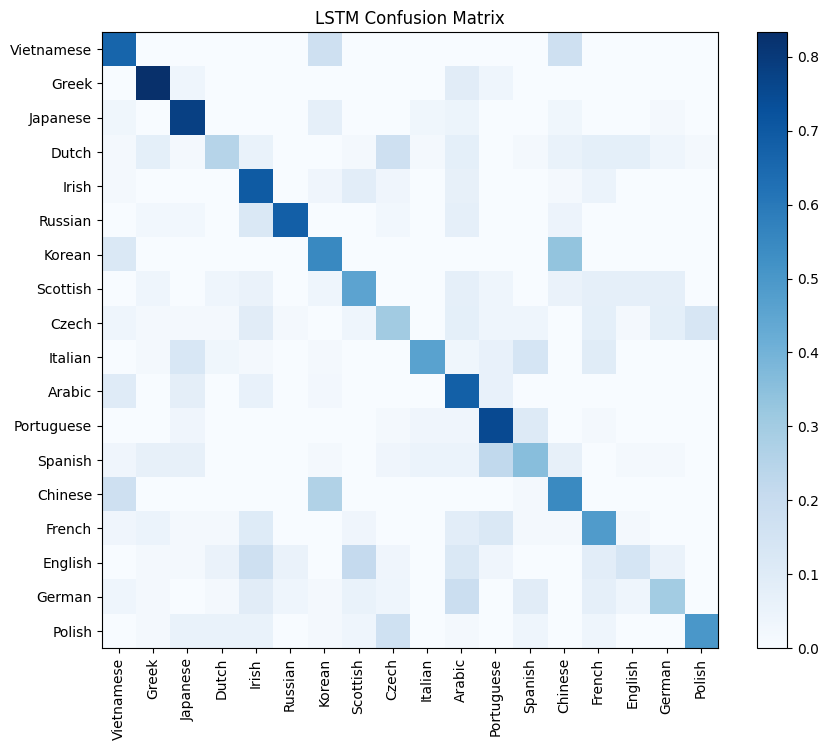

In [21]:
confusion_lstm = torch.zeros(n_categories, n_categories)
correct_lstm = 0
total_lstm = 0

for _ in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_example()
    output = evaluate_lstm(line_tensor)
    guess = output.topk(1)[1].item()
    category_index = all_categories.index(category)
    confusion_lstm[category_index][guess] += 1

    if guess == category_index:
        correct_lstm += 1
    total_lstm += 1

for i in range(n_categories):
    confusion_lstm[i] = confusion_lstm[i] / confusion_lstm[i].sum()

accuracy_lstm = correct_lstm / total_lstm
print(f"LSTM Accuracy: {accuracy_lstm * 100:.2f}%")

plt.figure(figsize=(10, 8))
plt.imshow(confusion_lstm.numpy(), interpolation='nearest', cmap='Blues')
plt.title('LSTM Confusion Matrix')
plt.colorbar()
plt.xticks(range(n_categories), all_categories, rotation=90)
plt.yticks(range(n_categories), all_categories)
plt.show()
